To consider:

1. When splitting train and test set, dont do a random split but use maybe 80% old data and 20% newest data.
E.g. sklearn.model_selection.TimeSeriesSplit

2. XGBoost can automatically learn to take the value of the previous day into account when making predictions, but it may be helpful to include the previous day's value as a feature to improve the model's accuracy.

Including the previous day's value as a feature will explicitly tell the model to consider this information when making predictions. This can be particularly helpful if the relationship between the current day's value and the previous day's value is non-linear or complex.

Additionally, including lagged features (features from previous time periods) is a common practice in time-series forecasting and can help capture seasonality or trends in the data.

Therefore, it is recommended that you include the value of the previous day as a feature in your XGBoost model.

# Project

In this project the values of different bicylce counting stations in the city of Bremen, Germany are analyzed. The goals are: 

* Visualize datasets and get a deeper understanding of the presented data
* Answer general questions about the data like:
    * Is the bike traffic increasing/decreasing or approximately constant over time?
    * Did the COVID pandemic have an influence on the bike usage?
    * What are the most used bike ways and why?
* Train a machine learning model, to accurately forecast the bike traffic for a given day.

The data ranges from 01.01.2013 to 31.12.2022. 
In addtition to the data of the bicycle counting stations, further data (weather data, geo-locations, national holidays, school vacations) are added.

# Notebook

In the Model learning step, the prepared dataset from [2_EDA](https://drive.google.com/file/d/13lZZpxqlnX_ab3LFYcy-RCOlP0bP-o8M/view?usp=sharing) is loaded. Then different machine learning algorithms are trained and compared to each other.

<a name="content"></a>
# Content 

* [1. Import libraries and mount drive](#1)
* [2. Import datasets](#2)
* [3. Transform columns](#3)
* [4. Establish baseline benchmark](#4)
* [5. Training machine learning algorithms](#5)
    * [5.1. XGBoost](#5.1.)

<a name="1"></a>
# 1.&nbsp;Import libraries and mount drive
[Content](#content)

The following libraries will be used:

* numpy
* pandas
* sklearn
* xgboost

In [67]:
# Import libraries
#import datetime
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb

import matplotlib.pyplot as plt

In [53]:
# Mount google drive
from google.colab import drive

drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


<a name="2"></a>
#2.&nbsp;Import dataset
[Content](#content)

Next, we will import the processed dataset from [2_EDA](../Bike_usage_Bremen/2_EDA.ipynb).

In [54]:
# Set the pass to the data folder
path_data = "/content/drive/MyDrive/Colab Notebooks/Bike_usage_Bremen/data/"

In [55]:
# Import dataset

# We will also parse the date column as datetime64 and set it to the index column
df = pd.read_csv(path_data + "03_training_data/" + "2023-04-02_df_full.csv", 
                         parse_dates=[0], index_col=[0])

# Check the correct loading of dataset
df.head()

,Weekday,GrafMoltkeStrEast,GrafMoltkeStrWest,HastedterBrStr,LangemarckStrEast,LangemarckStrWest,Osterdeich,RadwegKleineWeser,SchwachhauserRing,WachmannStrAusSouth,...,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,Holiday,Vacation
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,261.0,290.0,381.0,312.0,308.0,870.0,410.0,391.0,514.0,...,9.1,6.9,0.0,233.0,19.4,50.4,1001.8,0,Neujahr,Weihnachtsferien
2013-01-02,2,750.0,876.0,1109.0,1258.0,1120.0,2169.0,1762.0,829.0,1786.0,...,7.1,1.8,0.0,246.0,20.2,40.0,1017.5,30,NaN,Weihnachtsferien
2013-01-03,3,931.0,1015.0,1603.0,1556.0,1480.0,2295.0,2287.0,1196.0,2412.0,...,10.6,0.9,0.0,257.0,23.8,45.7,1024.5,0,NaN,Weihnachtsferien
2013-01-04,4,500.0,587.0,1284.0,703.0,626.0,1640.0,1548.0,1418.0,964.0,...,9.7,0.0,0.0,276.0,25.2,48.2,1029.5,0,NaN,Weihnachtsferien
2013-01-05,5,1013.0,1011.0,1284.0,1856.0,1621.0,4128.0,4256.0,3075.0,2065.0,...,8.6,0.1,0.0,293.0,20.2,41.0,1029.9,0,NaN,Weihnachtsferien


<a name="3"></a>
# 3. Transform columns
[Content](#content)

We need to transform the columns `Holiday` and `Vacation` using `One-Hot-Encoding` to change the categorical columns to numerical columns. Then we need to drop the original columns.

In [56]:
# Use One Hot Encoder
OH_encoder = OneHotEncoder()
transformed_array = OH_encoder.fit_transform(df.loc[:,"Holiday": "Vacation"]).toarray()
df_holiday_vacation_transformed = pd.DataFrame(transformed_array, 
                              columns=OH_encoder.get_feature_names_out(), 
                              index = df.index)              
# Drop the columns with Holiday_nan and Vacation_nan as those hold no additional value          
df_holiday_vacation_transformed = df_holiday_vacation_transformed.drop(["Holiday_nan", "Vacation_nan"], axis=1)

# Drop the old categorical columns Holiday and Vacation
df_transformed = df.drop(["Holiday", "Vacation"], axis=1)

# Add the new columns from OHE
df_transformed = pd.concat([df_transformed, df_holiday_vacation_transformed], axis=1)

We will add the year, month and day as seperate columns to give the algorithm the chance to pick up more granular and seasonal patterns.

In [57]:
df_date = pd.DataFrame(data = {
    "Year": df.index.year,
    "Month": df.index.month,
    "Day": df.index.day
}, index=pd.to_datetime(df.index.values))
    
df_transformed_date = pd.concat([df_date, df_transformed], axis=1)

df_transformed_date.head()

,Year,Month,Day,Weekday,GrafMoltkeStrEast,GrafMoltkeStrWest,HastedterBrStr,LangemarckStrEast,LangemarckStrWest,Osterdeich,...,Holiday_Pfingstmontag,Holiday_Reformationstag,Holiday_Tag der Arbeit,Holiday_Tag der Deutschen Einheit,Vacation_Herbstferien,Vacation_Osterferien,Vacation_Pfingstferien,Vacation_Sommerferien,Vacation_Weihnachtsferien,Vacation_Winterferien
2013-01-01,2013,1,1,1,261.0,290.0,381.0,312.0,308.0,870.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2013-01-02,2013,1,2,2,750.0,876.0,1109.0,1258.0,1120.0,2169.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2013-01-03,2013,1,3,3,931.0,1015.0,1603.0,1556.0,1480.0,2295.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2013-01-04,2013,1,4,4,500.0,587.0,1284.0,703.0,626.0,1640.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2013-01-05,2013,1,5,5,1013.0,1011.0,1284.0,1856.0,1621.0,4128.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Now, after all those transformations, we have out final dataset, to train our machine learning algorithms on.

<a name="4"></a>
# 4. Establish baseline benchmark
[Content](#content)


For our current task of creating model to predict the amount of cyclers for a given day, we do not have any baseline accuracy to predict the value that we could use, to measure our model against. 
For this reason, we will create a naive baseline model. For this, we will simply predict the amount of a day based on the value of previous day.

In [58]:
# Evaluate the model's performance using RMSE

# Select the `Total` column as our y_test and preds arrays
y_test = preds = df.loc[:,"Total"]

rmse = 0
length = y_test.shape[0]

# Loop from 0 to second last entry, as we can only use seconds last entry to
# predict the last entry of series
for i in range(length-1):
    # The mean_sqared_error function expects an array as input, therfore we 
    # concatenate the range from current value to current value + 1 (excluding)
    rmse += np.sqrt(mean_squared_error(y_test[i+1:i+2], preds[i:i+1]))

# Divide rmse value by number of pairs
rmse = rmse / (length-1)
print("RMSE: %f" % (rmse))

RMSE: 9083.225418


If we were naivly predicting the current value with the last value, we get an error over the entire dataset of approximately $9,111$. 

This is our naive benchmark to compare our model against. 

<a name="5"></a>
# 5. Training machine learning algorithms
[Content](#content)

<a name="5.1."></a>
## 5.1. XGBoost
[Content](#content)

In [85]:
# Shift the values in column_A by one day and assign to column_B
df_transformed_date['prev_Total_1'] = df_transformed_date['Total'].shift(1)
df_transformed_date['prev_Total_2'] = df_transformed_date['Total'].shift(2)
df_transformed_date['prev_Total_3'] = df_transformed_date['Total'].shift(3)

# Replace the first value of column_B with NaN, since there is no previous day value for the first row
df_transformed_date.loc[df_transformed_date.index[0], 'prev_Total_1'] = np.NAN
df_transformed_date.loc[df_transformed_date.index[1], 'prev_Total_2'] = np.NAN
df_transformed_date.loc[df_transformed_date.index[2], 'prev_Total_3'] = np.NAN

# Drop any rows that have NaN in column_B
#df_transformed_date = df.dropna(subset=['prev_Total'])

df_transformed_date.loc[:,["prev_Total_1", "prev_Total_2", "prev_Total_3","Total"]]

,prev_Total_1,prev_Total_2,prev_Total_3,Total
2013-01-01,NaN,NaN,NaN,5795.0
2013-01-02,5795.0,NaN,NaN,19494.0
2013-01-03,19494.0,5795.0,NaN,24851.0
2013-01-04,24851.0,19494.0,5795.0,13475.0
2013-01-05,13475.0,24851.0,19494.0,30643.0
...,...,...,...,...
2022-12-27,9520.0,8067.0,11206.0,19231.0
2022-12-28,19231.0,9520.0,8067.0,16241.0
2022-12-29,16241.0,19231.0,9520.0,18006.0
2022-12-30,18006.0,16241.0,19231.0,19176.0


In [59]:
df_transformed_date.columns
df_transformed_date["Total"]

2013-01-01     5795.0
2013-01-02    19494.0
2013-01-03    24851.0
2013-01-04    13475.0
2013-01-05    30643.0
               ...   
2022-12-27    19231.0
2022-12-28    16241.0
2022-12-29    18006.0
2022-12-30    19176.0
2022-12-31    10105.0
Name: Total, Length: 3652, dtype: float64

**Trying removing highly correlated features**

In [86]:
# Load the data into a pandas dataframe
data = df_transformed_date

# Define the features and target
# Higly correlated features have been removed (tavg, tmax, wpgt)

features = ['Year', 'Month', 'Day', 'Weekday',
       'tmax', 'prcp', 'snow', 'wspd', 'pres', 'tsun',
       'Holiday_1. Weihnachtsfeiertag', 'Holiday_2. Weihnachtsfeiertag',
       'Holiday_Christi Himmelfahrt', 'Holiday_Karfreitag', 'Holiday_Neujahr',
       'Holiday_Ostermontag', 'Holiday_Pfingstmontag',
       'Holiday_Reformationstag', 'Holiday_Tag der Arbeit',
       'Holiday_Tag der Deutschen Einheit', 'Vacation_Herbstferien',
       'Vacation_Osterferien', 'Vacation_Pfingstferien',
       'Vacation_Sommerferien', 'Vacation_Weihnachtsferien',
       'Vacation_Winterferien', "prev_Total_1", "prev_Total_2", "prev_Total_3"]

target = 'Total'

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], 
                                                    test_size=0.2, shuffle=True, random_state=0)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1.0, learning_rate = 0.01, 
                          max_depth = 12, n_estimators = 1000, reg_alpha = 0.1, reg_lambda = 1.0, 
                          subsample = 0.8, min_child_weight=5)

xg_reg.fit(X_train, y_train)

# Predict on the test set
preds = xg_reg.predict(X_test)

# Evaluate the model's performance using RMSE
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 6120.667363


05.03.2023 21:07 -> RMSE: 7399.339481 with NaN values for OHE instead of 0 values
05.03.2023 21:07 -> RMSE: 7406.339481 with 0 values for OHE instead of 0 values

March last value: RMSE: 6496.620309

02.04.23: 6468

In [87]:
# Load the data into a pandas dataframe
data = df_transformed_date

# Define the features and target
# Highly correlated features have been removed (tavg, tmax, wpgt)
features = ['Year', 'Month', 'Day', 'Weekday',
            'tmax', 'prcp', 'snow', 'wspd', 'pres', 'tsun',
            'Holiday_1. Weihnachtsfeiertag', 'Holiday_2. Weihnachtsfeiertag',
            'Holiday_Christi Himmelfahrt', 'Holiday_Karfreitag', 'Holiday_Neujahr',
            'Holiday_Ostermontag', 'Holiday_Pfingstmontag',
            'Holiday_Reformationstag', 'Holiday_Tag der Arbeit',
            'Holiday_Tag der Deutschen Einheit', 'Vacation_Herbstferien',
            'Vacation_Osterferien', 'Vacation_Pfingstferien',
            'Vacation_Sommerferien', 'Vacation_Weihnachtsferien',
            'Vacation_Winterferien', "prev_Total_1", "prev_Total_2", "prev_Total_3"]
target = 'Total'

# Split the data into training and test sets
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(data):
    X_train, X_test = data.iloc[train_index][features], data.iloc[test_index][features]
    y_train, y_test = data.iloc[train_index][target], data.iloc[test_index][target]

    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=1.0, learning_rate=0.01,
                              max_depth=12, n_estimators=1000, reg_alpha=0.1, reg_lambda=1.0,
                              subsample=0.8, min_child_weight=5)

    xg_reg.fit(X_train, y_train)

    # Predict on the test set
    preds = xg_reg.predict(X_test)

    # Evaluate the model's performance using RMSE
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print("RMSE: %f" % (rmse))


RMSE: 7127.157045
RMSE: 6843.915770
RMSE: 6808.748428
RMSE: 7121.689867
RMSE: 6898.040513


In [ ]:
print(X_train)
print(y_train)

params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [700, 1000, 1200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.1, 0.5, 1.0],
    'reg_lambda': [0.1, 0.5, 1.0],
    'min_child_weight': [1, 5, 10]
}

xg_reg = xgb.XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(xg_reg, param_grid=params, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

NameError: ignored

In [ ]:
#{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'subsample': 0.8}

In [ ]:
i = 0

print(y_test[i])
print(preds[i])
print(np.abs(y_test[i]-preds[i]))
print()

26957.0
30868.05
3911.05078125



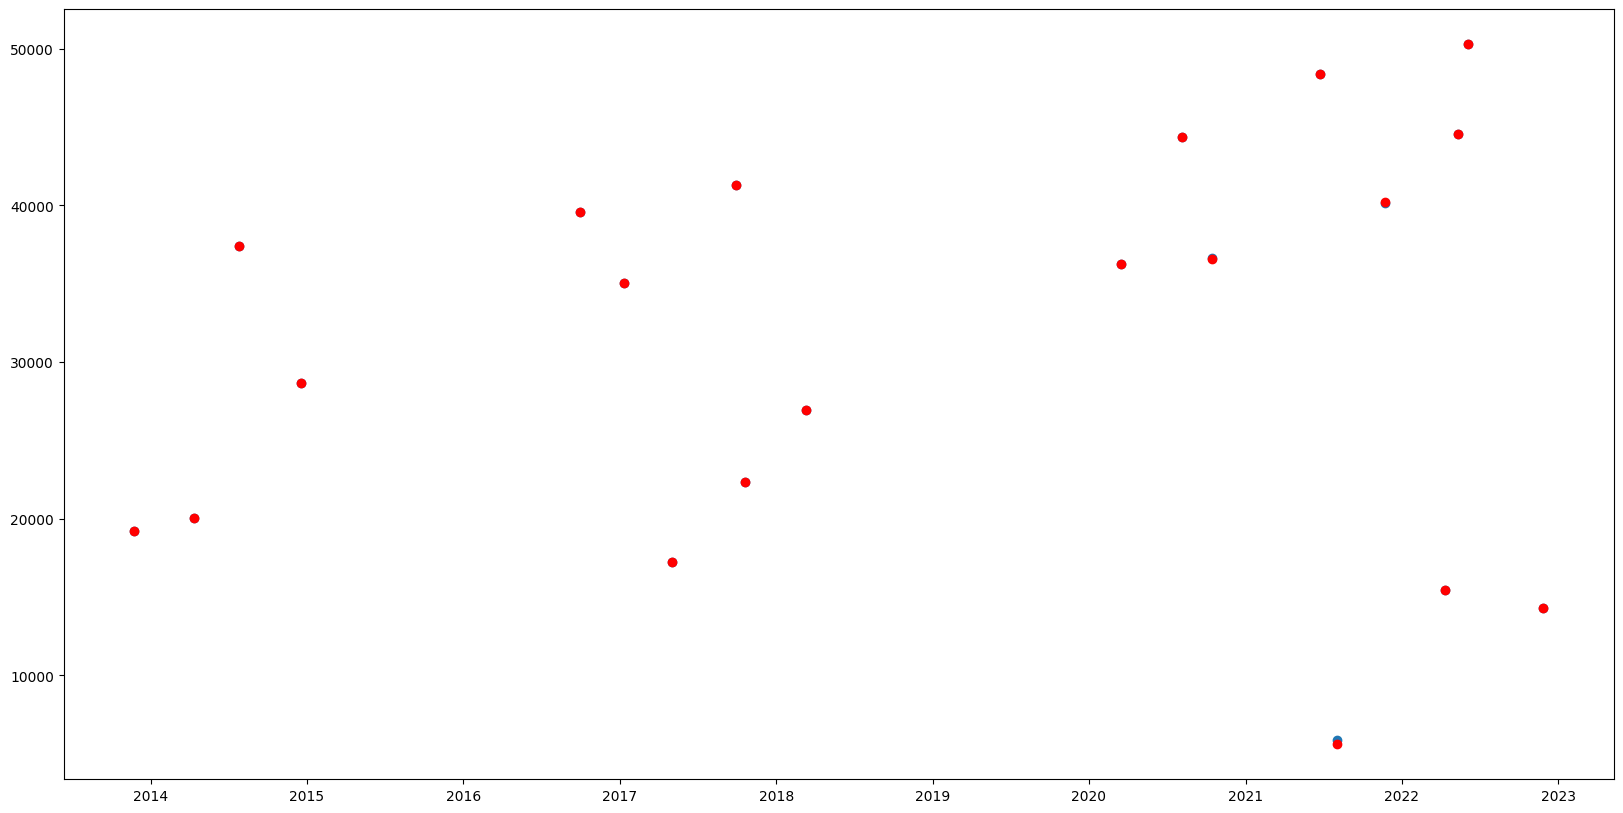

In [50]:
plt.figure(figsize=(20,10))
plt.scatter(y_test.index[:20], y_test[:20])
plt.scatter(y_test.index[:20], preds[:20], color="red")